<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/SNR_BAPipelineAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import warnings
warnings.filterwarnings('ignore')

Устанавливаем класс с алгоритмами генерации

In [20]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-l2ulx0v8
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-l2ulx0v8
  Resolved https://github.com/Karasiari/graphmcf.git to commit 44969b6315e0821cf50ac106fdaa5f91f8a870d5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Подключаем солвер MCF для проверки наших алгоритмов типа "friendly-adversarial"

In [21]:
import numpy as np

import cvxpy as cp
import networkx as nx

from dataclasses import dataclass
from typing import Optional

@dataclass(frozen=True)
class Solution:
    problem: cp.Problem
    flow: np.ndarray
    add_bandwidth: Optional[np.ndarray] = None
    gamma: Optional[float] = None
    traffic_mat: Optional[float] = None

    def to_vector(self) -> np.ndarray:
        sol_parts = [self.flow.T.flatten()]
        if self.add_bandwidth is not None:
            sol_parts.append(self.add_bandwidth)
        if self.gamma is not None:
            sol_parts.append(self.gamma)
        return np.hstack(sol_parts)


def vector_to_solution(graph: nx.DiGraph, vec: np.ndarray, problem_type: str):
    m, n = graph.number_of_edges(), graph.number_of_nodes()
    flow = vec[: m * n].reshape(n, m).T
    add_bandwidth = None
    gamma = None
    if problem_type in ["opt_network_min_cost_concurrent_flow", "opt_network_max_concurrent_flow"]:
        add_bandwidth = vec[m * n : m * n + m]
    if problem_type in ["max_concurrent_flow", "opt_network_max_concurrent_flow"]:
        gamma = vec[-1]
    return Solution(problem=None, flow=flow, add_bandwidth=add_bandwidth, gamma=gamma)

# Вспомогательные

def get_incidence_matrix(graph: nx.DiGraph) -> np.ndarray:
    """
    Construct incidence matrix
    :param graph: nx.DiGraph,: graph with attribute cost on edges
    :return:
        incidence_matrix: ndarray of shape (num_nodes, num_edges), incidence matrix
    """
    incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)
    incidence_matrix = incidence_matrix.toarray()
    return incidence_matrix

def get_weights(graph: nx.DiGraph) -> np.ndarray:
    """
    Extract edge weights
    :param graph: nx.DiGraph, graph with weights on edges
    :param key: str, name of attribute to obtain weights
    :return:
        weights: ndarray of shape (num_nodes), all edge weights in graph
    """
    edges_with_weights = [(edge, data['weight']) for edge, data in graph.edges.items()]
    edges_with_weights_dict = {key: value for key, value in edges_with_weights}
    return np.array(list(edges_with_weights_dict.values()), dtype=np.float64)

def get_var_value(var: Optional[cp.Variable]) -> Optional[float | np.ndarray]:
    """
    Get cvxpy.Variable value if not None
    :param var: cvxpy.Variable, variable to extract value
    :return:
        value: var.value if var is not None, else None
    """
    return var.value if var is not None else None


# Решение

def solve_throughput(graph: nx.Graph, traffic_lapl: np.ndarray, **solver_kwargs) -> Solution:
    graph = nx.DiGraph(graph)
    incidence_mat = get_incidence_matrix(graph)
    bandwidth = get_weights(graph)

    flow = cp.Variable((len(graph.edges), traffic_lapl.shape[0]))
    gamma = cp.Variable()
    prob = cp.Problem(
        cp.Maximize(gamma),
        [cp.sum(flow, axis=1) <= bandwidth, incidence_mat @ flow == -gamma * traffic_lapl.T, flow >= 0, gamma >= 0],
    )
    prob.solve(**solver_kwargs)

    if prob.status != "optimal":
        gamma = None

    return Solution(problem=prob, flow=get_var_value(flow), gamma=get_var_value(gamma))

Проверим на 10 маленьких графах SNR-BA (30 вершин) - capacity одинаковое для всех ребер (по примеру cola capacity = 80)

Формируем выборку

In [22]:
%pip install "git+https://github.com/Karasiari/snr-ba.git"

  Cloning https://github.com/Karasiari/snr-ba.git to /tmp/pip-req-build-d_roc63w
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/snr-ba.git /tmp/pip-req-build-d_roc63w
  Resolved https://github.com/Karasiari/snr-ba.git to commit b34c556e8e90c174685ebfdef6a50c33d088d9bf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [23]:
from snr_ba_generator import *

import random

import numpy as np
from typing import List, Tuple

def generate_uniform_nodes(n: int,
                           seed: int = 0,
                           xlim: Tuple[float, float] = (0.0, 1.0),
                           ylim: Tuple[float, float] = (0.0, 1.0),
                           ) -> List[Tuple[float, float]]:
    rng = random.Random(seed)
    return [(rng.uniform(*xlim), rng.uniform(*ylim)) for _ in range(n)]

def run_experiments(num_experiments=3, num_nodes=30, radii=None, capacity=80.0, seed=0):
    if radii is None:
        radii = np.linspace(0, geodesic_distance([0, 0], [1, 1]), 20).tolist()

    snr_ba_graphs = []
    for exp in range(num_experiments):

        # 1) Generate nodes
        coords = generate_uniform_nodes(num_nodes, seed=seed + exp)

        # 2) Build SNR-BA graph (reuses your snr_ba_from_latlon)
        G_snrba = snr_ba_from_latlon(coords, m=2, theta=5.0, seed=seed + exp)
        adj_matrix_nx = nx.adjacency_matrix(G_snrba, weight=None)
        adj_matrix = adj_matrix_nx.toarray()
        adj_matrix_weighted = adj_matrix * capacity
        snr_ba_graphs.append(adj_matrix_weighted)
    return snr_ba_graphs

num_experiments = 10
snr_ba_graphs = run_experiments(num_experiments=num_experiments, num_nodes=30, capacity=80.0)
snr_ba_graphs_for_test = {}
for i in range(num_experiments):
  snr_ba_graphs_for_test[f'SNR-BA graph #{i+1}'] = {'adj_matrix': snr_ba_graphs[i]}

Пишем дополнительные функции для простого запуска алгоритма по выборкам параметров

In [24]:
import random
import numpy as np
from graphmcf.core import GraphMCF
from graphmcf.demands import GravitationalGenerator, MCFGeneratorMultiGraph, MCFGeneratorMultiEdges
from graphmcf.data import compute_laplacian_matrix

def gravity_results(graph, beta, dyn_k):

  graph_gravity = GraphMCF(graph['adj_matrix'])
  graph_size = graph_gravity.n
  median_capacity = np.median([data['weight'] for u, v, data in graph_gravity.graph.edges(data=True) if 'weight' in data])
  gen = GravitationalGenerator(beta=beta, intensity=int(3*median_capacity*graph_size), centrality='pagerank', edge_perc=1/graph_size, edge_mode='dynamic', dyn_max=1, dyn_law='exponential', dyn_k=dyn_k)
  res = gen.generate(graph_gravity)

  demands_laplacian = compute_laplacian_matrix(graph_gravity.demands_graph)
  sol = solve_throughput(graph_gravity.graph, demands_laplacian)
  gamma = sol.gamma

  return (beta, gamma)


def multigraph_results(graph, alpha):

  graph_multigraph = GraphMCF(graph['adj_matrix'])
  graph_size = graph_multigraph.n
  gen = MCFGeneratorMultiGraph(epsilon=0.025,
                               p_ER = 2/graph_size, distribution="normal", median_weight_for_initial=20, var_for_initial=1, multi_max=5,
                               num_edges=None,
                               initial_generation='deterministic', demands_sum=int(1.5*graph_size*20),)
  res = gen.generate(graph=graph_multigraph, alpha_target=alpha)

  demands_laplacian = compute_laplacian_matrix(graph_multigraph.demands_graph)
  sol = solve_throughput(graph_multigraph.graph, demands_laplacian)
  gamma = sol.gamma

  return (alpha, gamma, abs(alpha - res.alpha_history[-1]) < 0.025)

def old_results(graph, alpha):

  graph_oldgraph = GraphMCF(graph['adj_matrix'])
  graph_size = graph_oldgraph.n
  gen = MCFGeneratorMultiEdges(epsilon=0.025,
                               p_ER = 2/graph_size, distribution="normal", median_weight_for_initial=20, var_for_initial=1,
                               demands_median_denominator=8, demands_var_denominator=16,
                               num_edges=None,
                               update_type_old="replace_weight", update_type_new="replace_weight",)
  res = gen.generate(graph=graph_oldgraph, alpha_target=alpha)

  demands_laplacian = compute_laplacian_matrix(graph_oldgraph.demands_graph)
  sol = solve_throughput(graph_oldgraph.graph, demands_laplacian)
  gamma = sol.gamma

  return (alpha, gamma, abs(alpha - res.alpha_history[-1]) < 0.025)

Случайно равномерно наберем параметров для проверки алгоритмов

In [25]:
sample_size = 30
betas_sample = [random.uniform(0, 1) for _ in range(sample_size)]
alphas_sample = [random.uniform(0, 1) for _ in range(sample_size)]

Визуализация зависимостей решения MCF от параметров алгоритмов

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def print_section_header(text, width=50):
    """Печатает заголовок раздела"""
    print("\n" + "\033[1m" + text + "\033[0m")
    print("-" * len(text))

def print_centered_title(text, width=80):
    """Печатает центрированный заголовок с жирным шрифтом (если терминал поддерживает)"""
    centered_text = text.center(width)
    # Попытка использовать жирный шрифт (работает в большинстве терминалов)
    print("\033[1m" + "=" * width + "\033[0m")
    print("\033[1m" + centered_text + "\033[0m")
    print("\033[1m" + "=" * width + "\033[0m")

def analyze_sample(x, y, name, ax, color='red'):
    """
    Анализирует одну выборку и строит график
    """

    x_clean = []
    y_clean = []
    for i in range(len(x)):
        try:
            x_val = float(x[i])
            y_val = float(y[i])
            # Проверяем, что не NaN и не Inf
            if np.isnan(x_val) or np.isinf(x_val) or np.isnan(y_val) or np.isinf(y_val):
                continue
            x_clean.append(x_val)
            y_clean.append(y_val)
        except (ValueError, TypeError):
            # Пропускаем пару, если преобразование не удалось
            continue

    if len(x_clean) < 2 or len(y_clean) < 2:

        # Создаем пустой график с сообщением
        ax.text(0.5, 0.5, 'Сошедшихся меньше 2',
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=12, color='red')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'{name}\nПлохая сходимость', fontweight='bold')
        ax.grid(True, alpha=0.3)
        return None, None

    x_array = np.array(x_clean, dtype=float)
    y_array = np.array(y_clean, dtype=float)

    # Вычисляем корреляцию Пирсона
    corr_coef, p_value = pearsonr(x_array, y_array)

    # Определяем статистическую значимость
    significance = "значим" if p_value < 0.05 else "не значим"

    # Выводим сводку
    print(f"Выборка: {name[1]}")
    print(f"Значение коэффициента корреляции Пирсона: {corr_coef:.4f}")
    print(f"Статзначимость результата при критическом значении 0.05: {significance} (p-value = {p_value:.4f})")
    print("-" * 50)

    # Строим график
    ax.scatter(x_clean, y_clean, color=color, alpha=0.7, s=30)
    ax.set_xlim(0, 1)  # Только по X фиксируем масштаб от 0 до 1
    if name[1] == 'gravity':
      ax.set_xlabel('beta')
    else:
      ax.set_xlabel('alpha target')
    ax.set_ylabel('gamma')
    ax.set_title(f'{name[1]}\nКорреляция: {corr_coef:.3f}')
    ax.grid(True, alpha=0.3)

    return corr_coef, p_value

Посмотрим результаты


Прогоним и сравним алгоритмы в смысле связи с gamma на SNR-BA графах


----------------------------------------------------------------------
                   Анализ для графа SNR-BA graph #1                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8877
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8587
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6363
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0002)
--------------------------------------------------


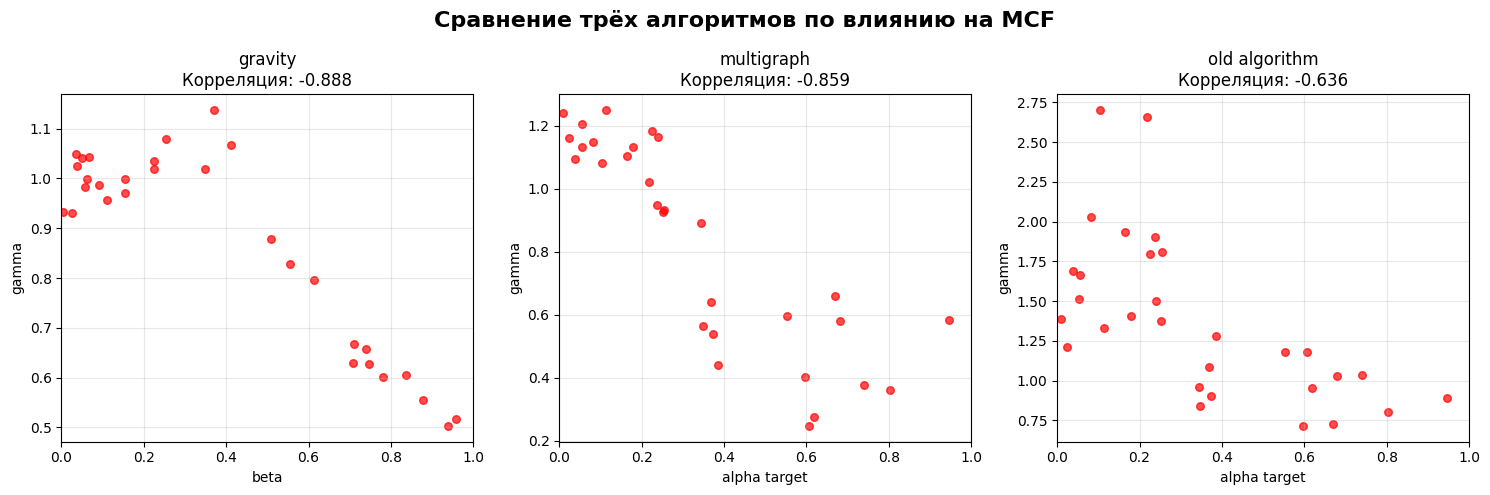

                   Анализ для графа SNR-BA graph #2                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9737
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8833
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6308
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0002)
--------------------------------------------------


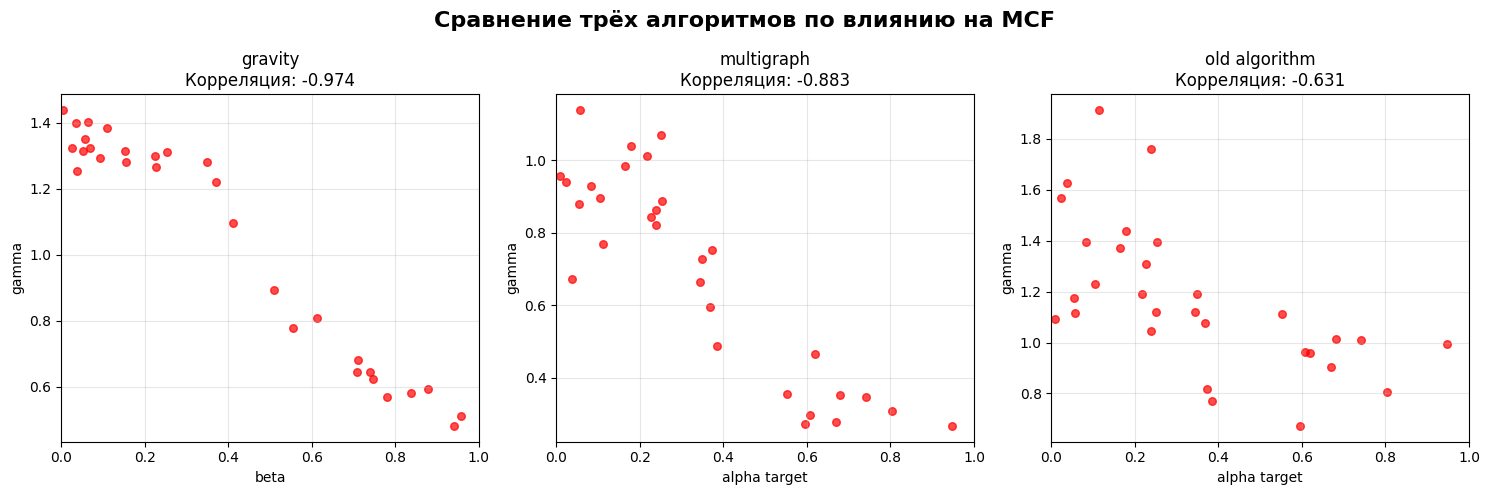

                   Анализ для графа SNR-BA graph #3                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.7504
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8169
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.4870
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0063)
--------------------------------------------------


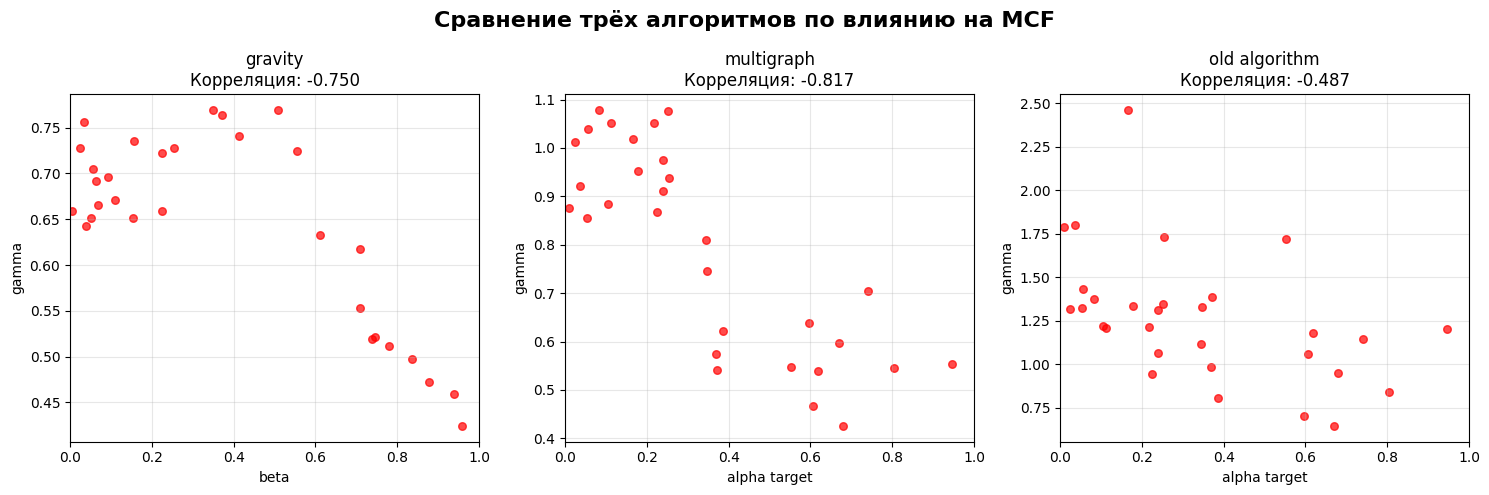

                   Анализ для графа SNR-BA graph #4                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8512
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8989
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.4670
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0093)
--------------------------------------------------


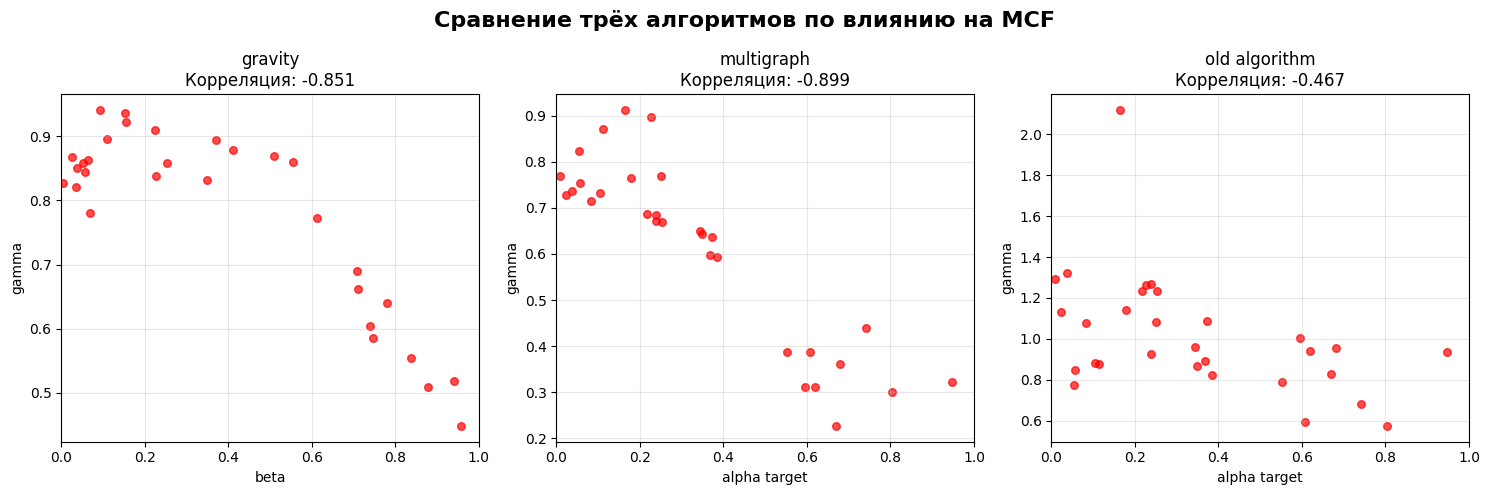

                   Анализ для графа SNR-BA graph #5                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9392
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.7991
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.5949
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0005)
--------------------------------------------------


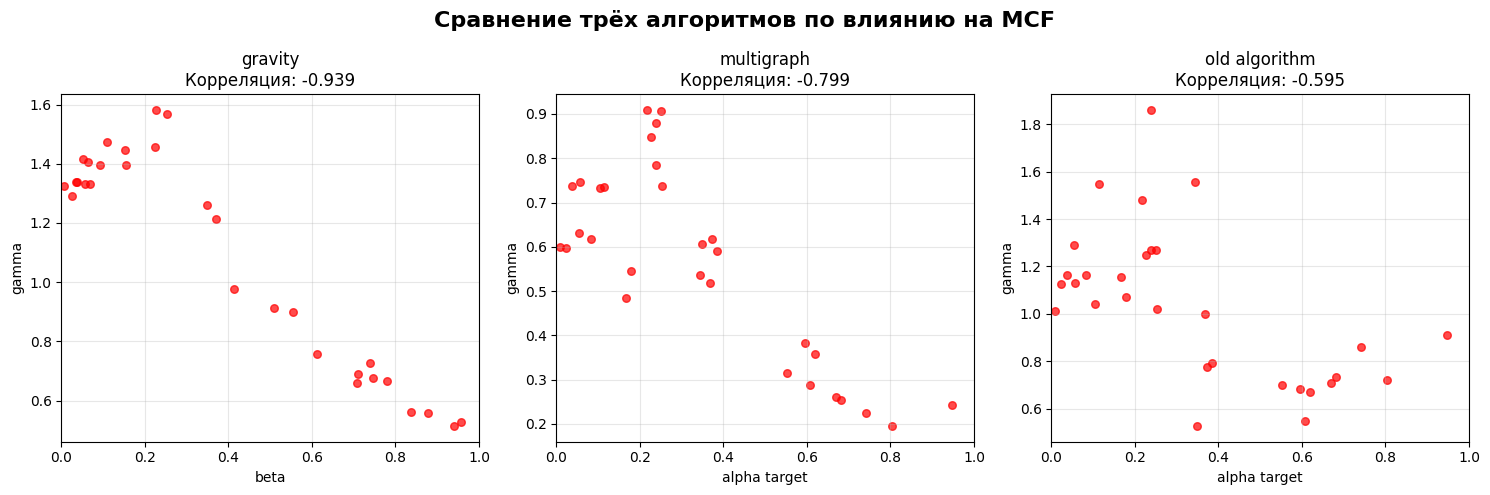

                   Анализ для графа SNR-BA graph #6                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9131
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8747
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7038
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------


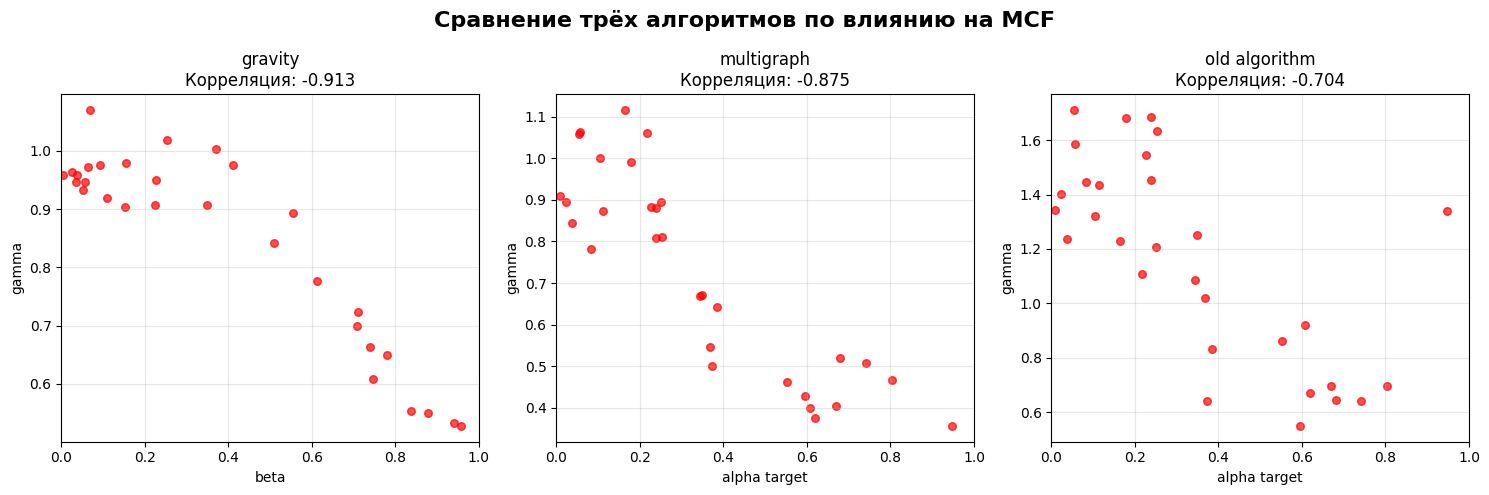

                   Анализ для графа SNR-BA graph #7                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8895
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8973
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6692
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0001)
--------------------------------------------------


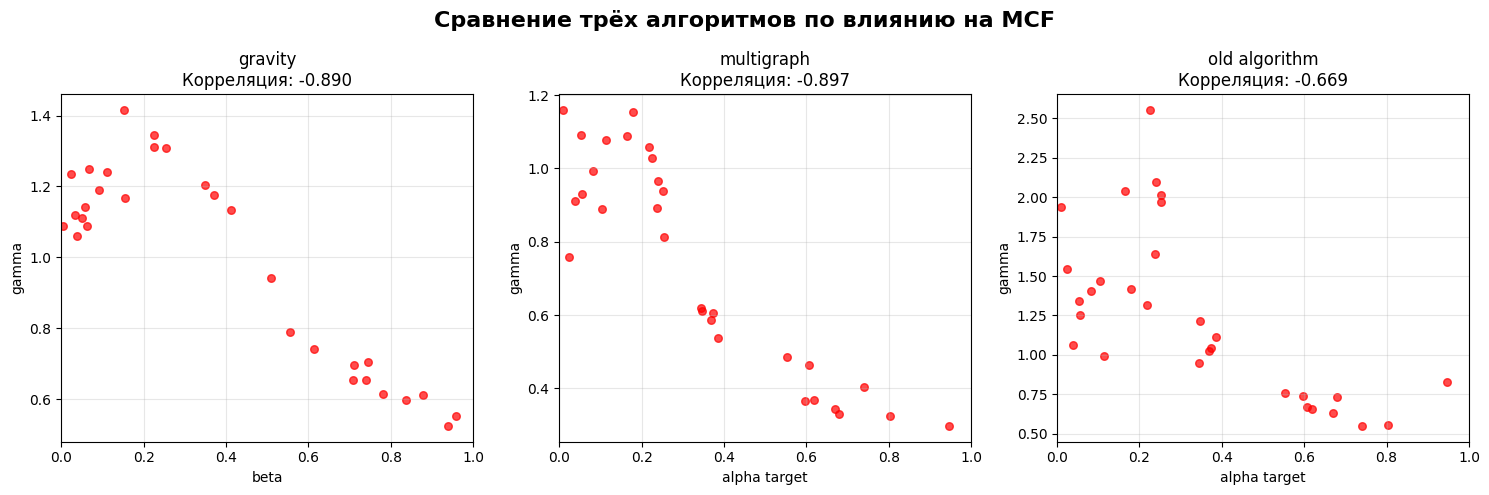

                   Анализ для графа SNR-BA graph #8                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.3843
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0360)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.7758
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.5062
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0043)
--------------------------------------------------


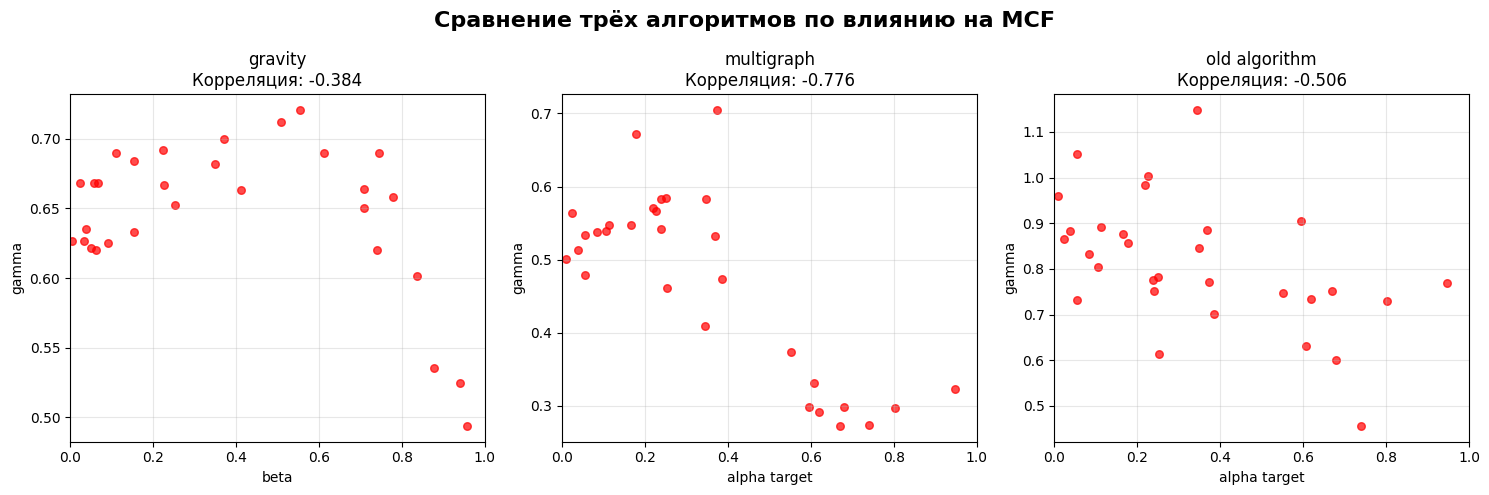

                   Анализ для графа SNR-BA graph #9                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9596
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9239
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.8114
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------


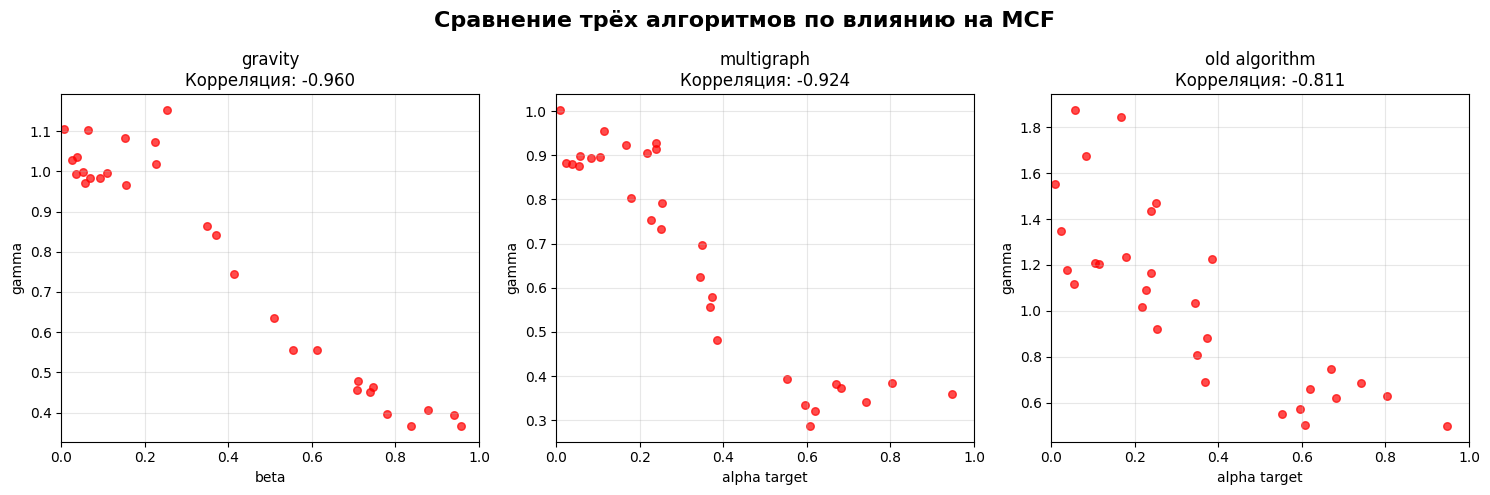

                  Анализ для графа SNR-BA graph #10                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9520
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8390
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7084
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------


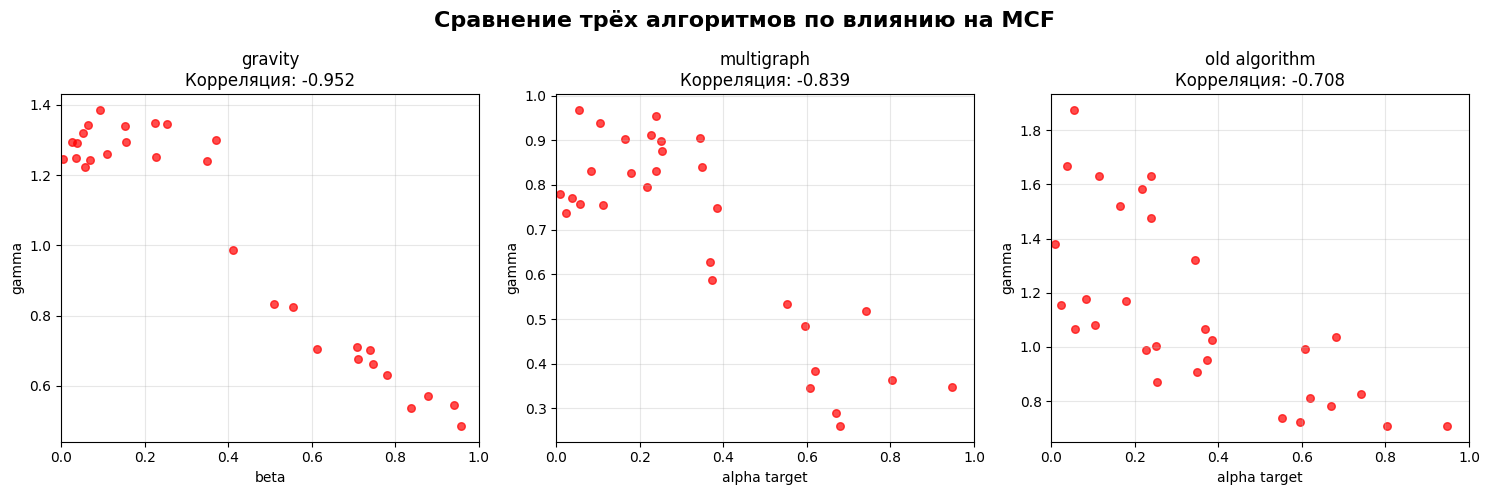

In [27]:
print_section_header("Прогоним и сравним алгоритмы в смысле связи с gamma на SNR-BA графах\n\n")
output_for_gravity = {}
output_for_multigraph = {}
output_for_old = {}
for name, graph in snr_ba_graphs_for_test.items():
  output_for_gravity[name] = []
  output_for_multigraph[name] = []
  output_for_old[name] = []
  for beta in betas_sample:
    output = gravity_results(graph, beta, dyn_k=0.95)
    output_for_gravity[name].append(output)
  for alpha in alphas_sample:
    output = multigraph_results(graph, alpha)
    output_for_multigraph[name].append(output)
    output = old_results(graph, alpha)
    output_for_old[name].append(output)

  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1]], [j for (i, j, flag) in sample[1]], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

А теперь для multigraph и old_algorithm оставим только те результаты, которые сошлись к alpha_target


То же, но для сошедшихся multigraph и old algorithm


-----------------------------------------------------
                   Анализ для графа SNR-BA graph #1                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8877
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9213
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.5556
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.0954)
--------------------------------------------------


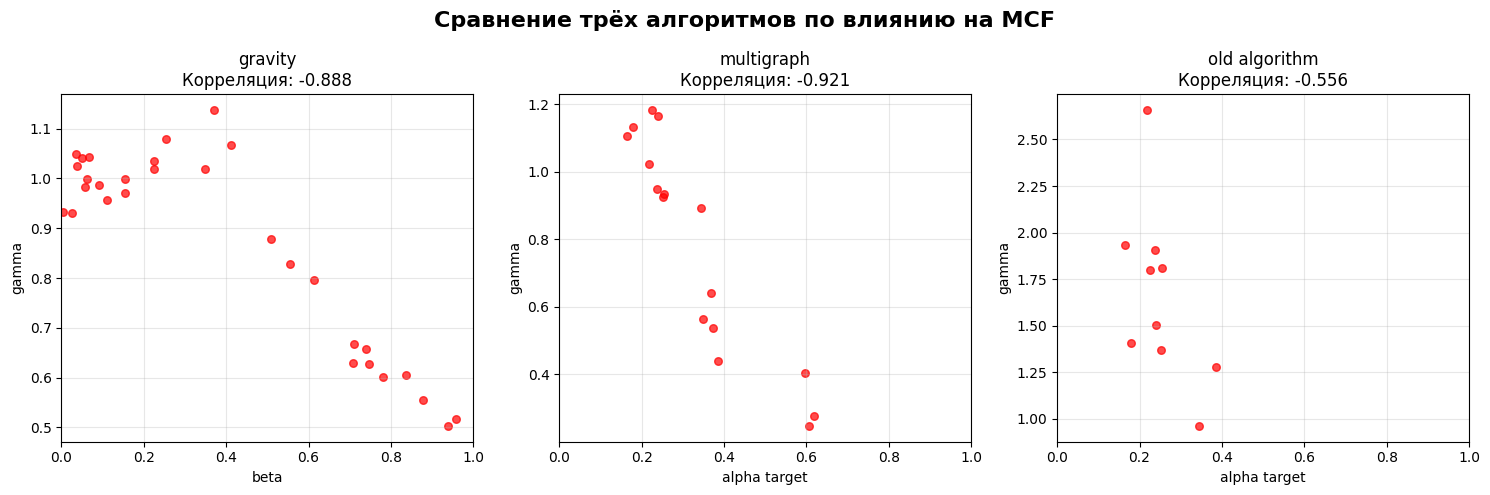

                   Анализ для графа SNR-BA graph #2                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9737
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9500
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6784
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0153)
--------------------------------------------------


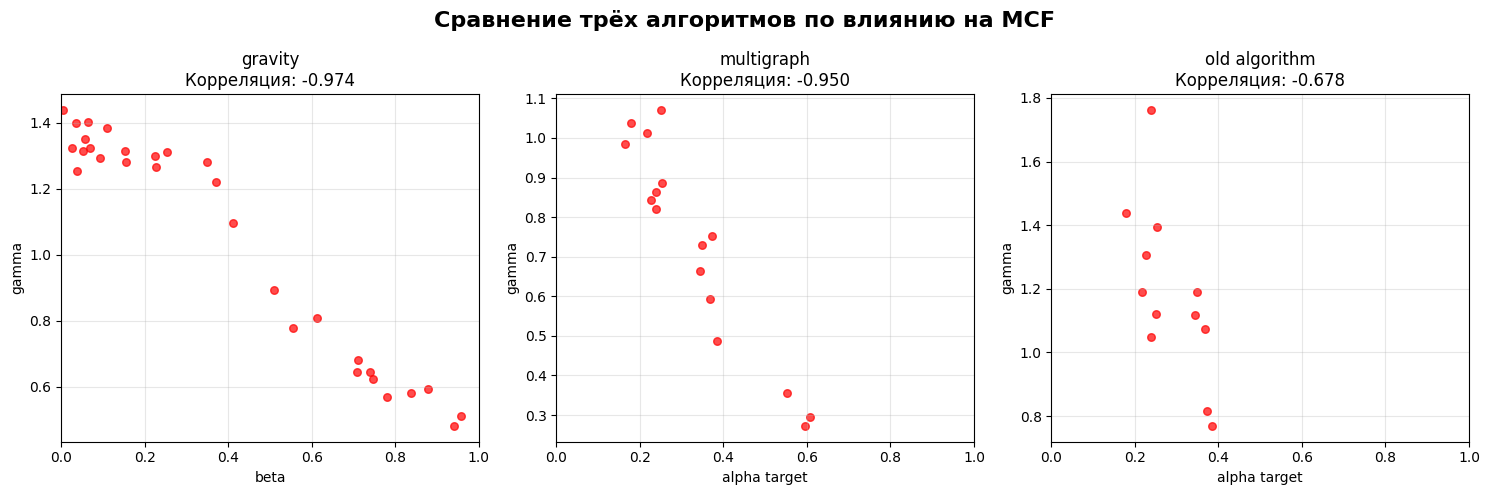

                   Анализ для графа SNR-BA graph #3                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.7504
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8730
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0001)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.2595
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.4410)
--------------------------------------------------


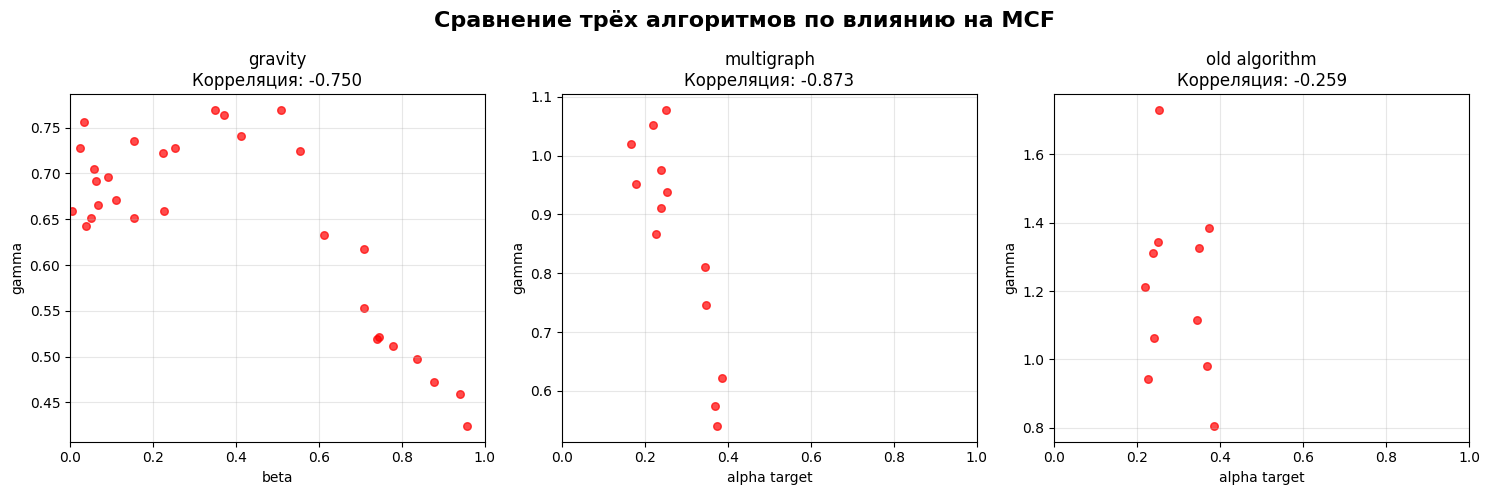

                   Анализ для графа SNR-BA graph #4                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8512
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9454
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7466
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0053)
--------------------------------------------------


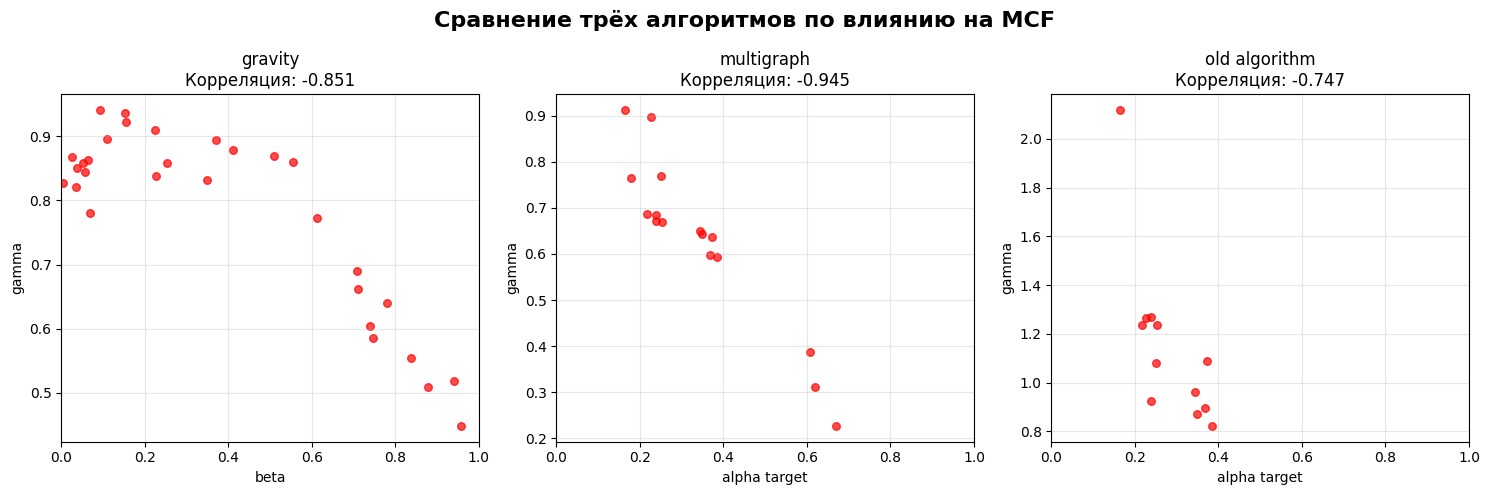

                   Анализ для графа SNR-BA graph #5                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9392
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9476
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.5680
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.0867)
--------------------------------------------------


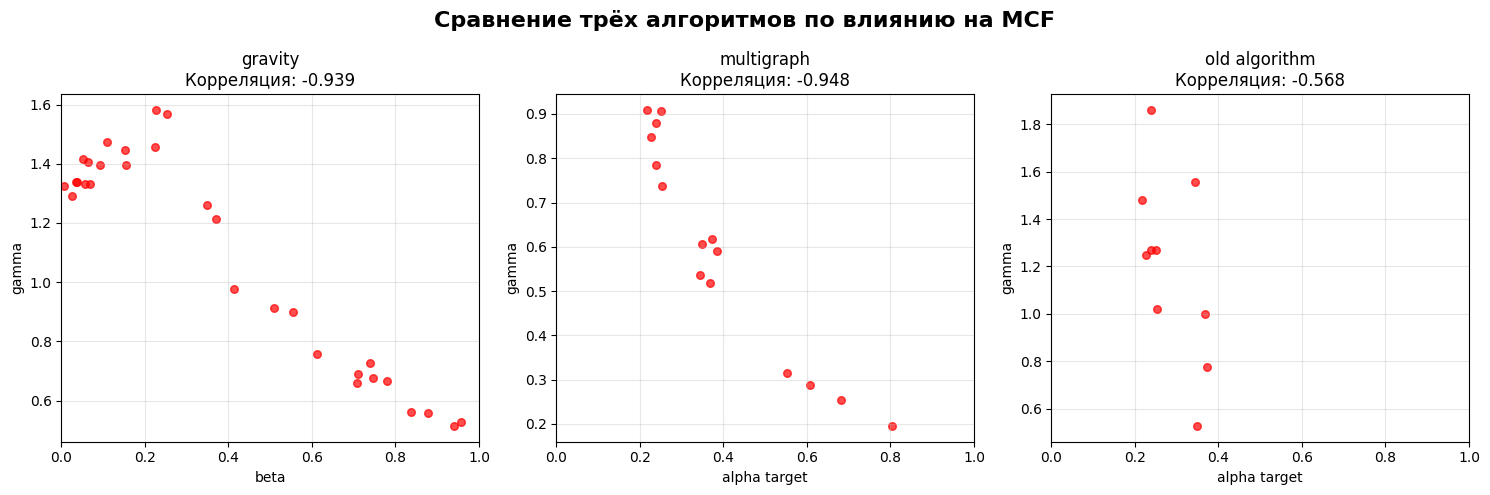

                   Анализ для графа SNR-BA graph #6                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9131
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9286
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7064
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0070)
--------------------------------------------------


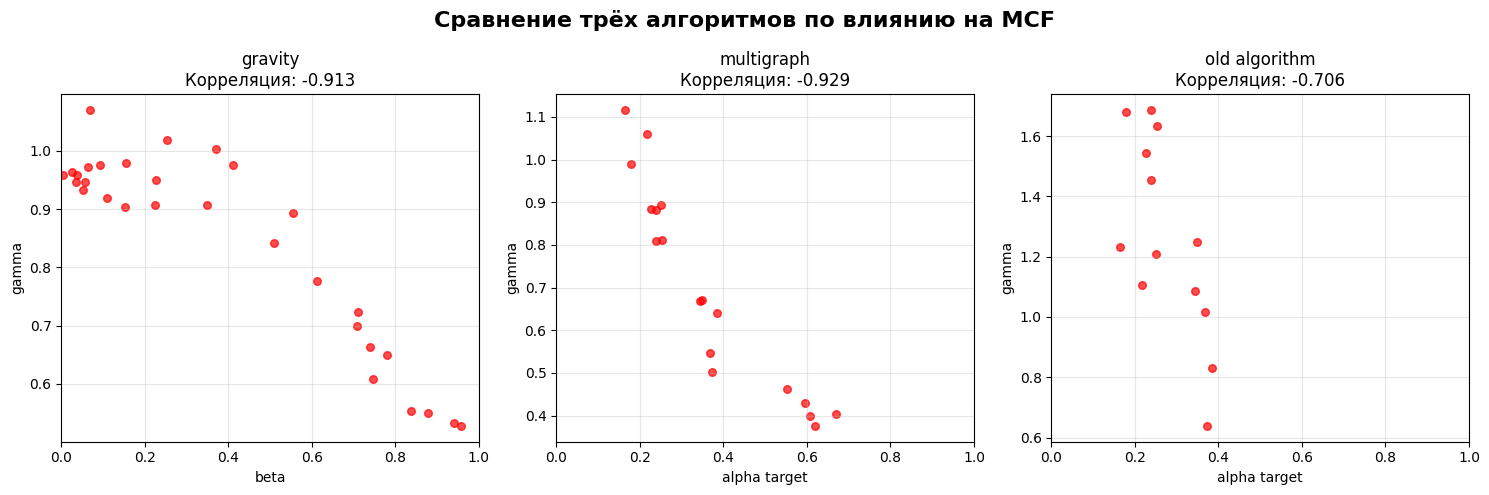

                   Анализ для графа SNR-BA graph #7                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8895
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9291
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7933
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0012)
--------------------------------------------------


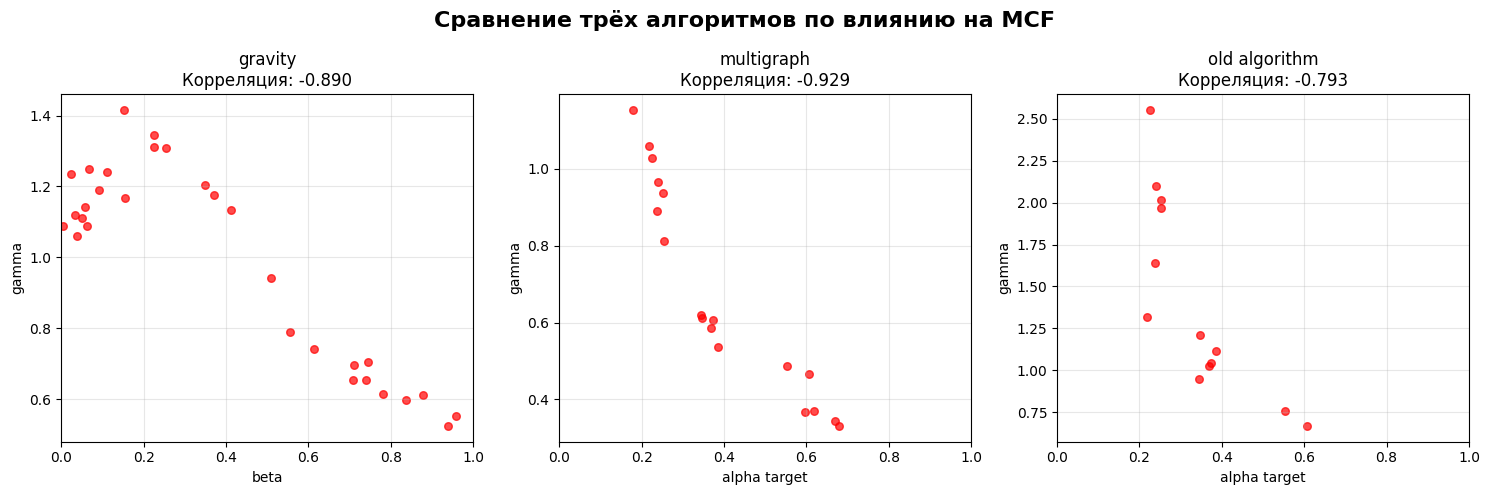

                   Анализ для графа SNR-BA graph #8                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.3843
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0360)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8754
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: 0.1473
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.6847)
--------------------------------------------------


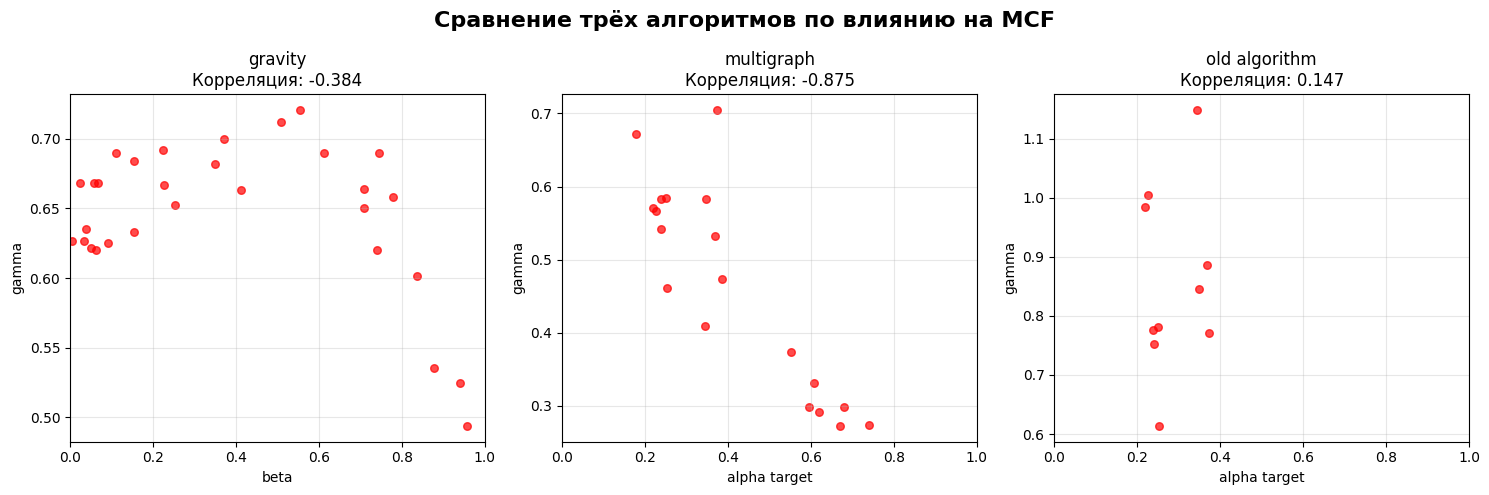

                   Анализ для графа SNR-BA graph #9                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9596
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9527
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6286
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0214)
--------------------------------------------------


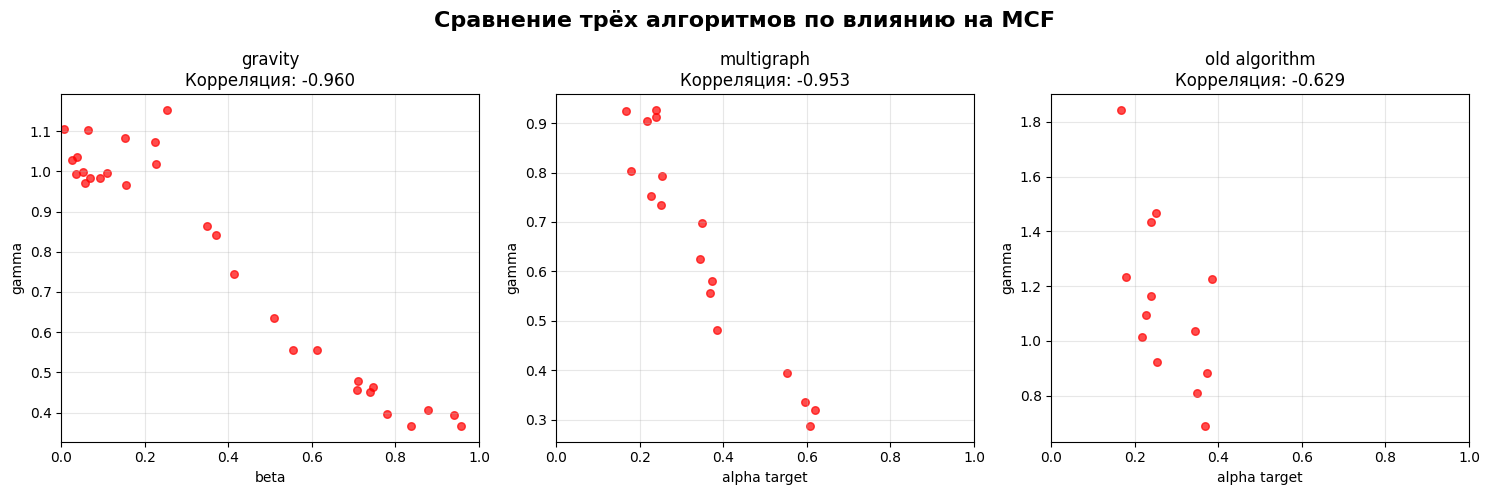

                  Анализ для графа SNR-BA graph #10                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9520
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9031
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.4536
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.1611)
--------------------------------------------------


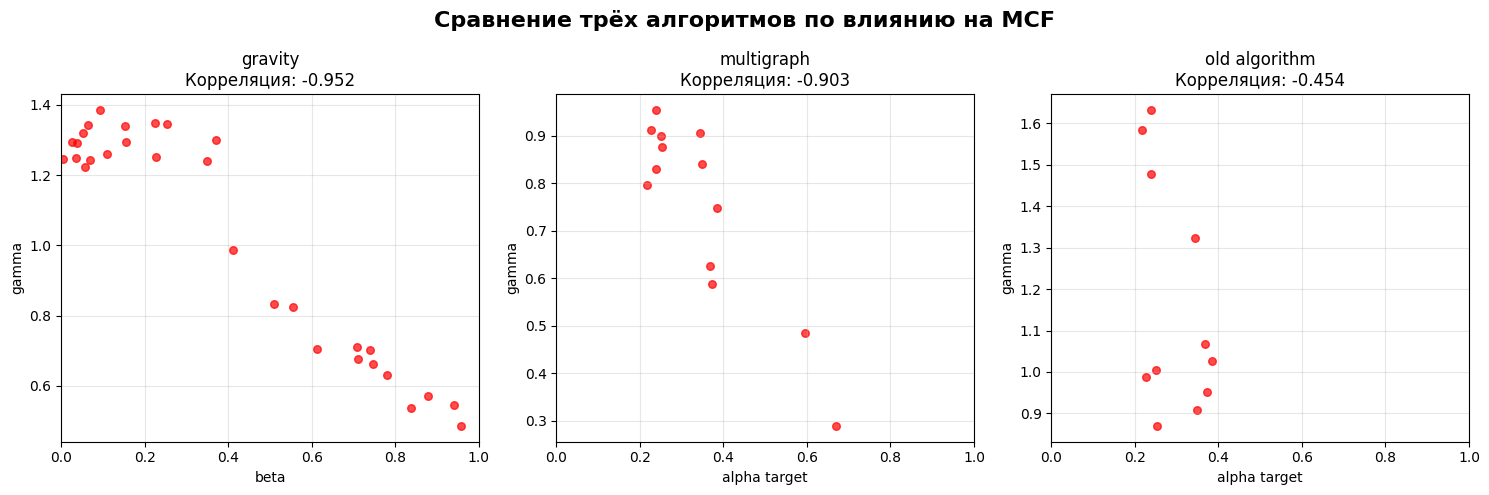

In [28]:
print_section_header("То же, но для сошедшихся multigraph и old algorithm\n\n")
for name, graph in snr_ba_graphs_for_test.items():
  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1] if flag], [j for (i, j, flag) in sample[1] if flag], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

Теперь возьмем выборки параметров более "линейно"

In [29]:
betas_sample = np.arange(0.05, 1.00, 0.025)
alphas_sample = np.arange(0.05, 1.00, 0.025)


Прогоним и сравним алгоритмы в смысле связи с gamma на SNR-BA графах


----------------------------------------------------------------------
                   Анализ для графа SNR-BA graph #1                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8998
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8467
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6556
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------


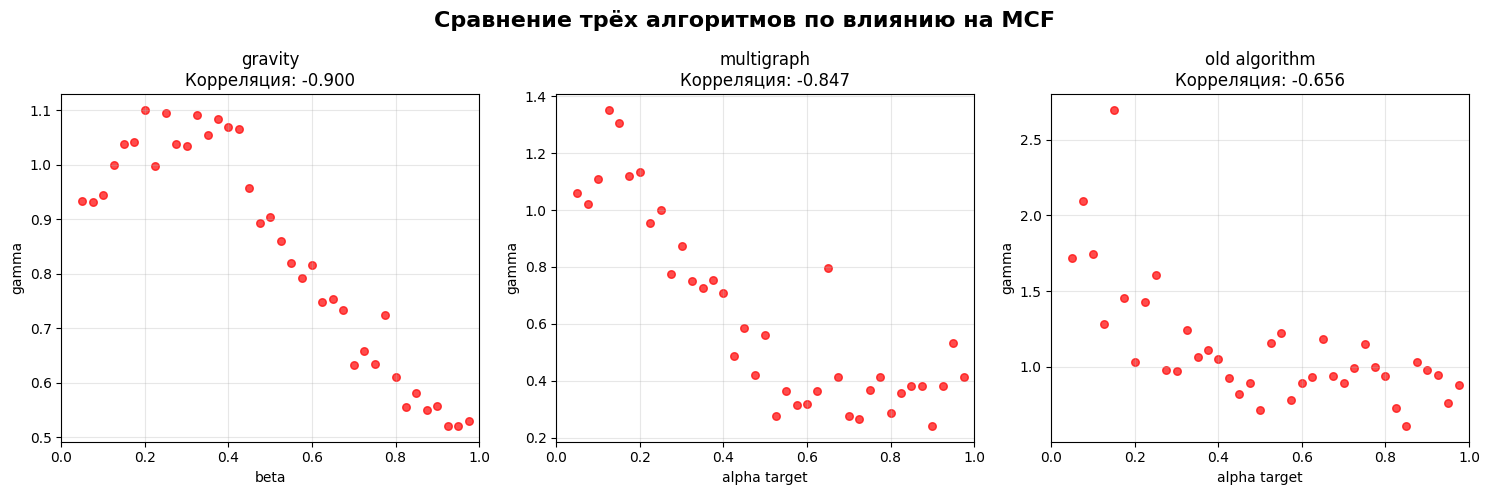

                   Анализ для графа SNR-BA graph #2                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9702
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8304
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.5600
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0003)
--------------------------------------------------


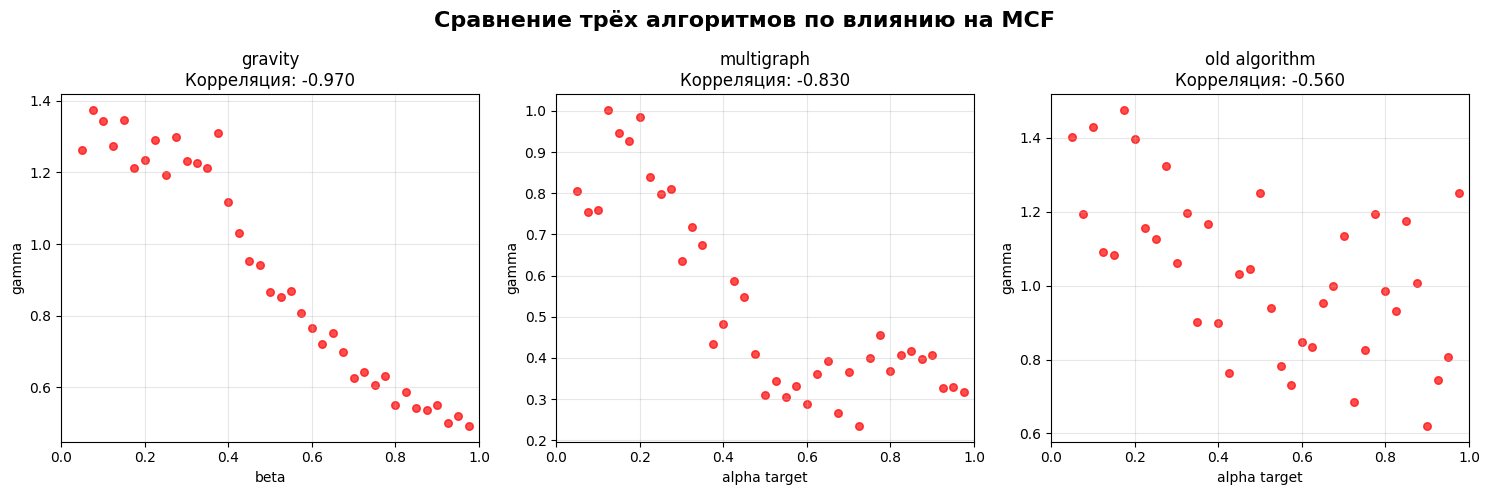

                   Анализ для графа SNR-BA graph #3                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.7411
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.7863
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.3201
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.0501)
--------------------------------------------------


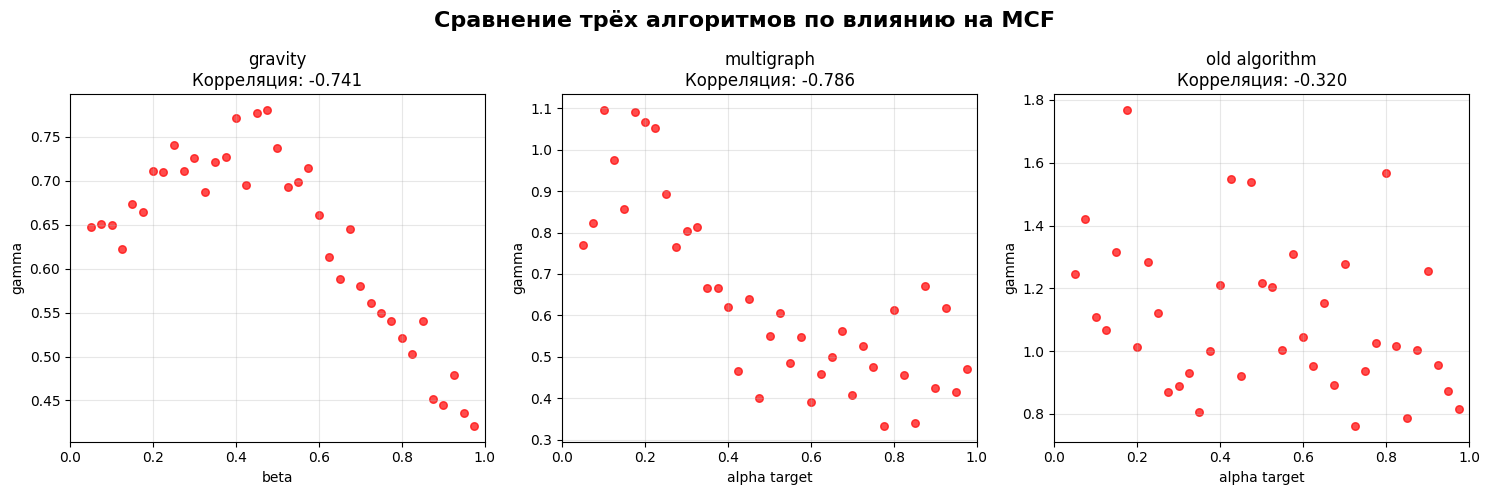

                   Анализ для графа SNR-BA graph #4                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8821
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8975
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6800
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------


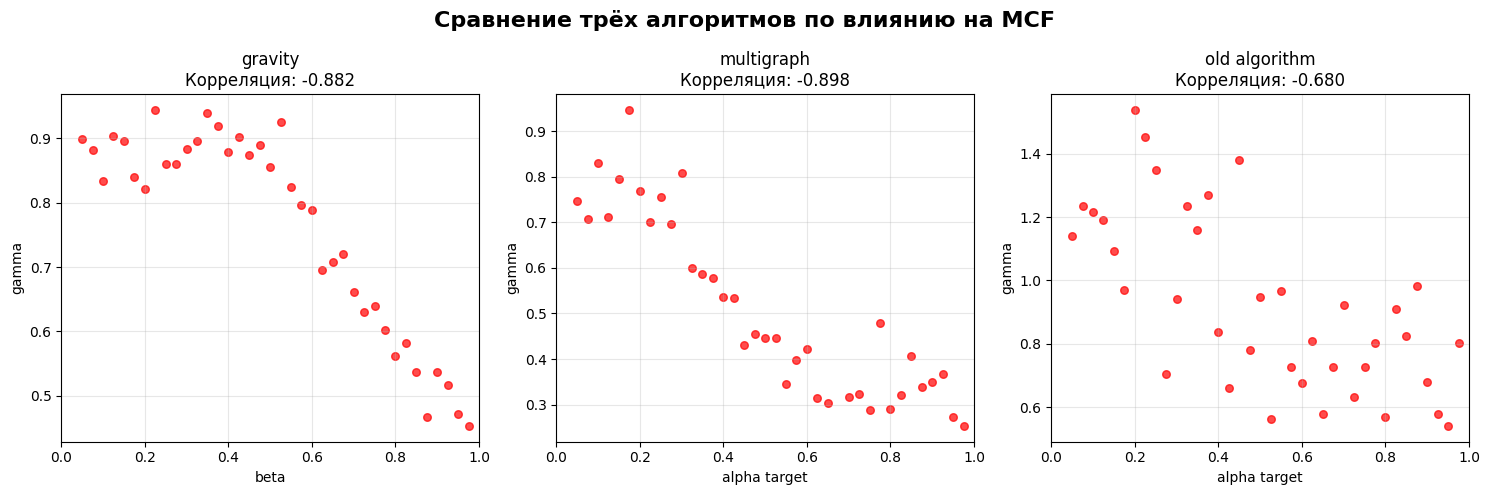

                   Анализ для графа SNR-BA graph #5                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9548
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.8664
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6517
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------


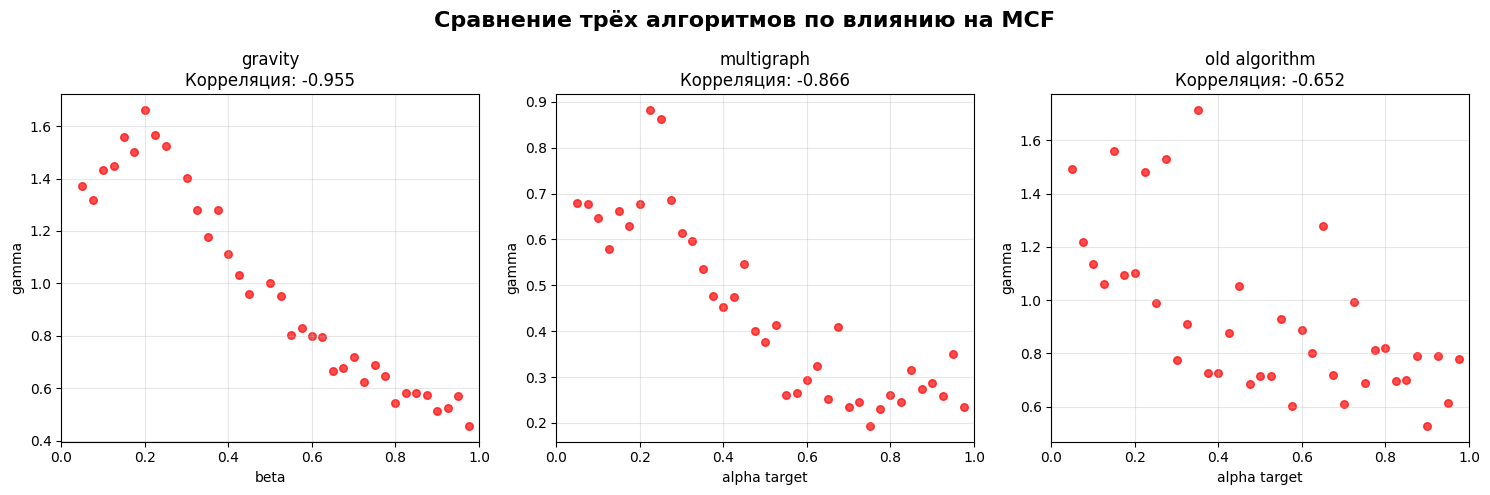

SolverError: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.

In [30]:
print_section_header("Прогоним и сравним алгоритмы в смысле связи с gamma на SNR-BA графах\n\n")
output_for_gravity = {}
output_for_multigraph = {}
output_for_old = {}
for name, graph in snr_ba_graphs_for_test.items():
  output_for_gravity[name] = []
  output_for_multigraph[name] = []
  output_for_old[name] = []
  for beta in betas_sample:
    output = gravity_results(graph, beta, dyn_k=0.95)
    output_for_gravity[name].append(output)
  for alpha in alphas_sample:
    output = multigraph_results(graph, alpha)
    output_for_multigraph[name].append(output)
    output = old_results(graph, alpha)
    output_for_old[name].append(output)

  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1]], [j for (i, j, flag) in sample[1]], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

И только для сошедшихся


То же, но для сошедшихся multigraph и old algorithm


-----------------------------------------------------
                   Анализ для графа SNR-BA graph #1                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8998
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9729
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.6320
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0370)
--------------------------------------------------


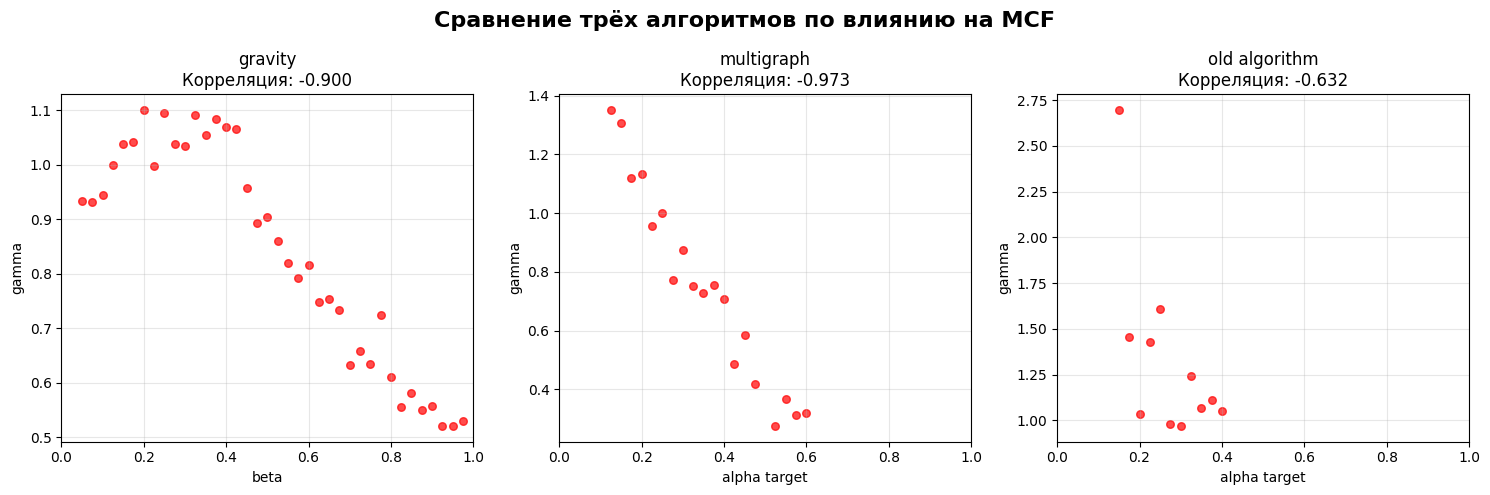

                   Анализ для графа SNR-BA graph #2                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9702
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9518
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7019
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0350)
--------------------------------------------------


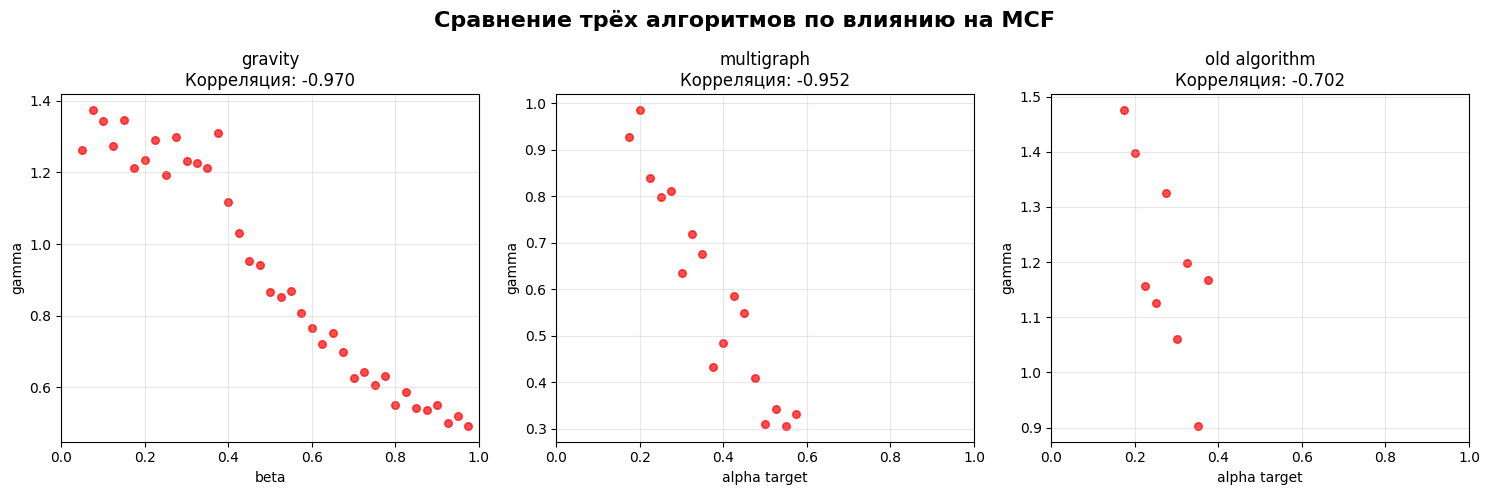

                   Анализ для графа SNR-BA graph #3                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.7411
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9084
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.7233
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.0662)
--------------------------------------------------


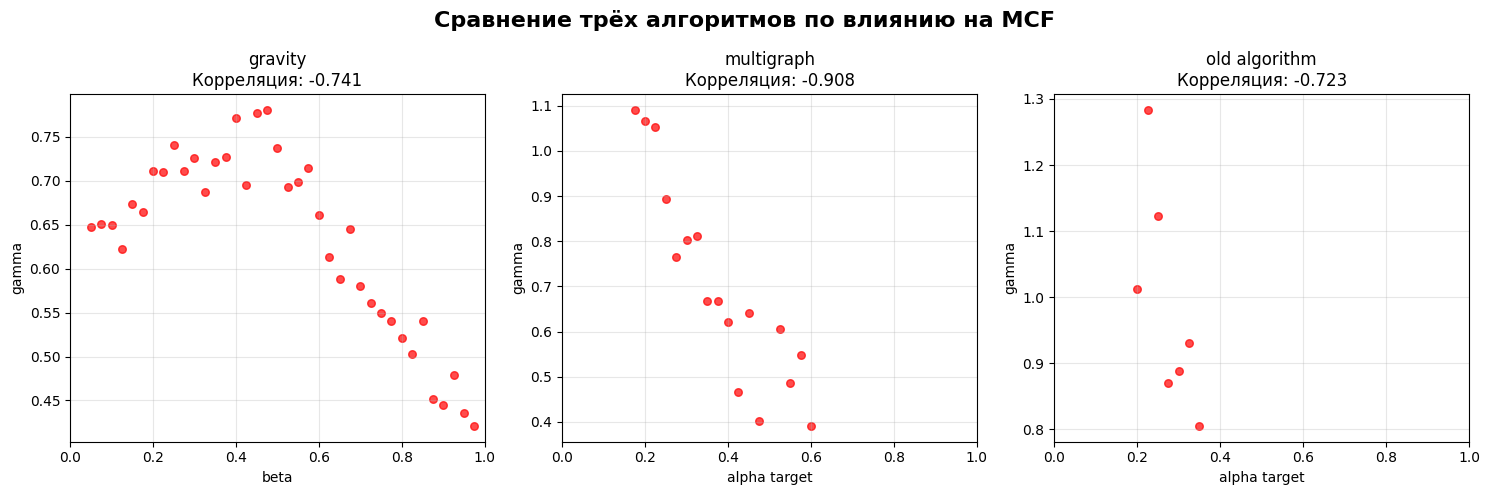

                   Анализ для графа SNR-BA graph #4                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.8821
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9483
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.2754
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.3862)
--------------------------------------------------


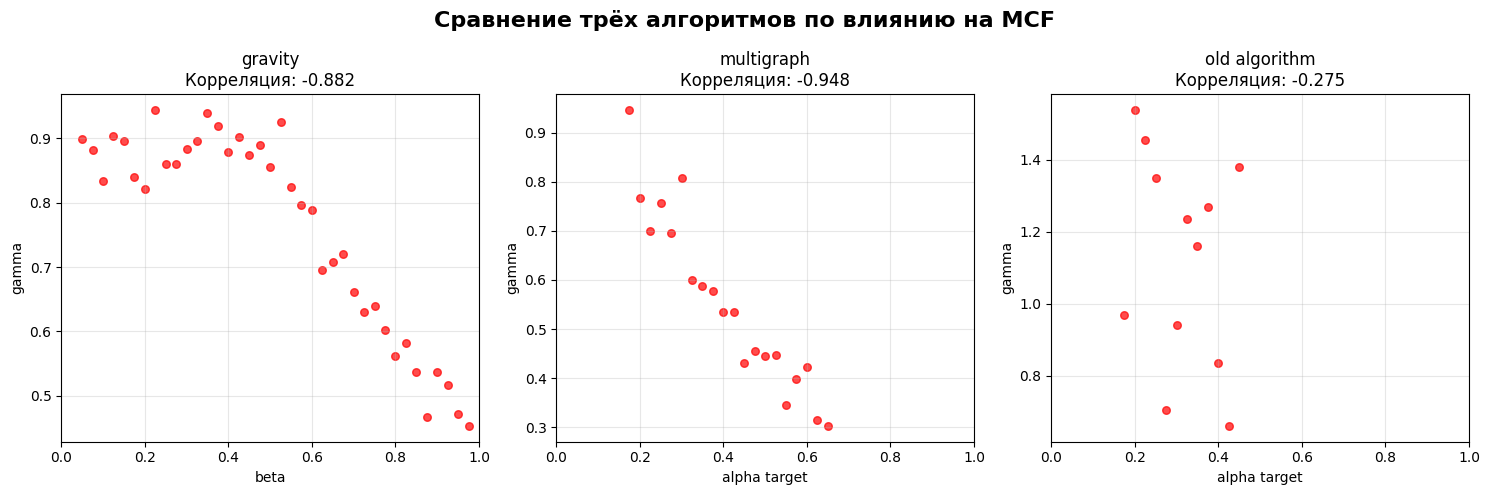

                   Анализ для графа SNR-BA graph #5                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: -0.9548
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: multigraph
Значение коэффициента корреляции Пирсона: -0.9308
Статзначимость результата при критическом значении 0.05: значим (p-value = 0.0000)
--------------------------------------------------
Выборка: old algorithm
Значение коэффициента корреляции Пирсона: -0.3633
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.3365)
--------------------------------------------------


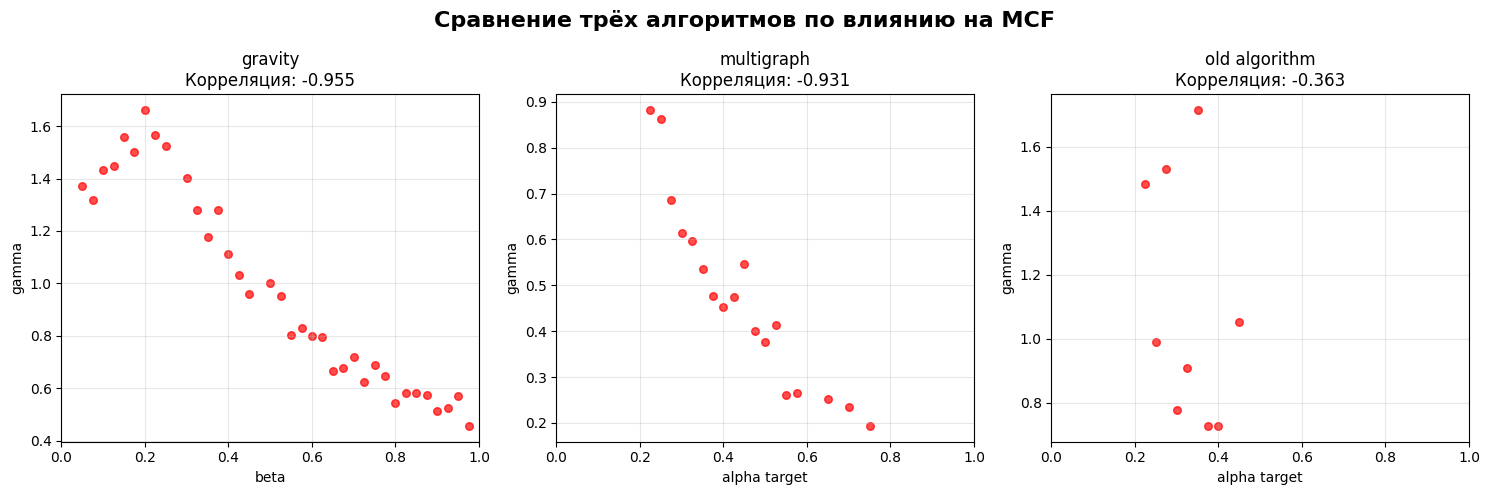

                   Анализ для графа SNR-BA graph #6                   

СТАТИСТИЧЕСКАЯ СВОДКА:
Выборка: gravity
Значение коэффициента корреляции Пирсона: 0.2191
Статзначимость результата при критическом значении 0.05: не значим (p-value = 0.4328)
--------------------------------------------------


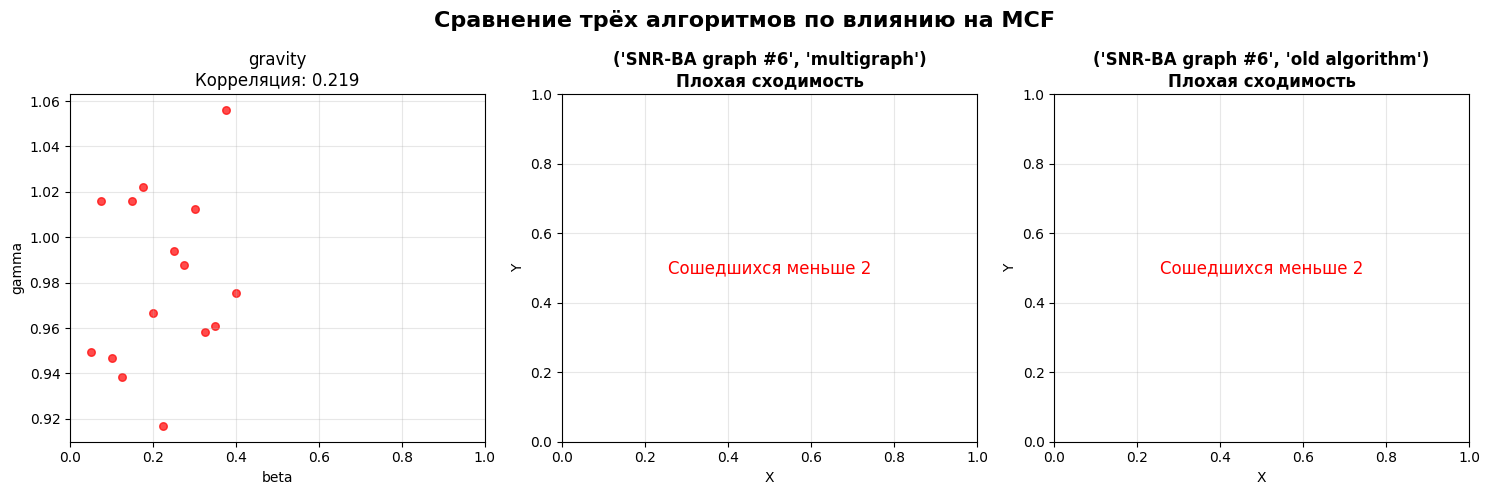

                   Анализ для графа SNR-BA graph #7                   

СТАТИСТИЧЕСКАЯ СВОДКА:


KeyError: 'SNR-BA graph #7'

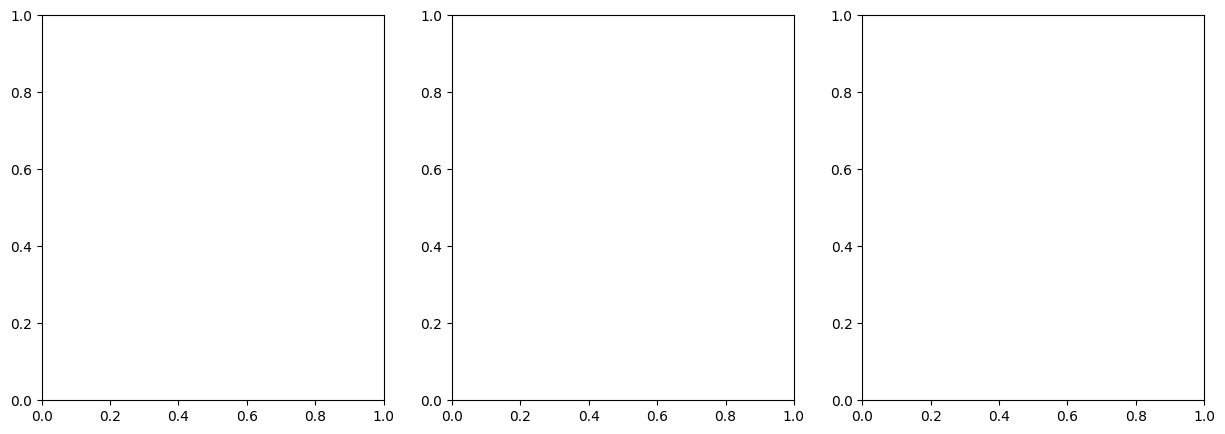

In [31]:
print_section_header("То же, но для сошедшихся multigraph и old algorithm\n\n")
for name, graph in snr_ba_graphs_for_test.items():
  print_centered_title(f'Анализ для графа {name}', 70)
  print("\nСТАТИСТИЧЕСКАЯ СВОДКА:")
  print("=" * 50)
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  samples = [('gravity', output_for_gravity[name]), ('multigraph', output_for_multigraph[name]), ('old algorithm', output_for_old[name])]
  for i, sample in enumerate(samples):
    if sample[0] == 'gravity':
      analyze_sample([i for (i, j) in sample[1]], [j for (i, j) in sample[1]], (name, sample[0]), axes[i])
    else:
      analyze_sample([i for (i, j, flag) in sample[1] if flag], [j for (i, j, flag) in sample[1] if flag], (name, sample[0]), axes[i])

  plt.suptitle('Сравнение трёх алгоритмов по влиянию на MCF', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()